# Moyenne mobile

In [ ]:
%matplotlib inline
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import time
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [610]:
df = pd.read_csv("C:/Users/Hass/Downloads/Master_IMSD/Réseau de Neurones/data_stocks.csv", sep=',')
df.head(2)

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.33,143.68,129.63,82.04,102.23,85.22,59.76,121.52,...,84.37,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.00,53.35
1,1491226260,2364.1001,42.36,143.70,130.32,82.08,102.14,85.65,59.84,121.48,...,84.37,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.77,53.35


In [611]:
df = df.copy()
df.DATE = pd.to_datetime(df.DATE, unit='s')
print(df.DATE.describe()[['count','first', 'last']])
print("du 3 avril 2017 au 31 aout 2017 : ")
print("""
151 jours ouvré = 4 months, 29 days (including the end date)
De 13h30 à 20h 
""")
df.head(1)

count                  41266
first    2017-04-03 13:30:00
last     2017-08-31 20:00:00
Name: DATE, dtype: object
du 3 avril 2017 au 31 aout 2017 : 

151 jours ouvré = 4 months, 29 days (including the end date)
De 13h30 à 20h 



,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,2017-04-03 13:30:00,2363.6101,42.33,143.68,129.63,82.04,102.23,85.22,59.76,121.52,...,84.37,119.035,44.4,39.88,82.03,7.36,50.22,63.86,122.0,53.35


In [612]:
df['Days'] = pd.to_datetime(df['DATE'].astype(str).str[:10])
df['Hours'] = df['DATE'].astype(str).str[-8:-3]

In [634]:
#data_stocks[[col for col in data_stocks.columns if 'AAPP' in col]]
df5 = df[["DATE", "Days","Hours","NASDAQ.AAPL"]].set_index('Days')
df5 = df5[df5.Hours == "20:00"][["NASDAQ.AAPL"]].rename(columns={"NASDAQ.AAPL":"Adj_Close"})
print(df5.shape)
df5.head()

(105, 1)


,Adj_Close
Days,
2017-04-03,143.700
2017-04-04,144.770
2017-04-05,144.020
2017-04-06,143.685
2017-04-07,143.340


In [623]:
df5 = df4.reset_index().rename(columns={'Days':'Date'})
df5.head(2)

,Date,Adj_close
0,2017-04-03,143.70
1,2017-04-04,144.77


In [624]:
df['DATE'].min(), df['DATE'].max()

(Timestamp('2017-04-03 13:30:00'), Timestamp('2017-08-31 20:00:00'))

# Introduction

L'objectif de cette partie est de prévoir le cours de l'action le lendemain en utilisant une moyenne mobile simple.
Compte tenu des prix des N derniers jours, nous faisons des prévisions pour le jour N+1.

Nous allons utiliser la dernière valeur pour faire une prédiction et nous nous intéressons au cours le plus communément utilisé pour calculer une moyenne mobile: le cours de clôture

In [556]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Text(0, 0.5, 'USD')

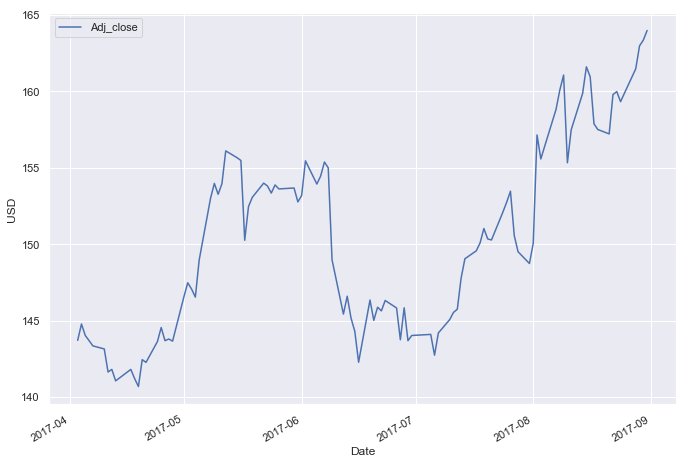

In [553]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df5.plot(x='Date', y='Adj_close', style='b-', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("USD")

Cette valeur observée chaque jours à la fermeture des marchées financiers sera la moyenne de valeurs observées précédement.
Nous utilisons la méthode de la moyenne mobile qui utilise le dernier ensemble de valeurs afin de prédire. Ce la dit, pour chaque étape, les valeurs prédites sont prises en compte tout en retirant la valeur observée la plus ancienne de l'ensemble. 

## Partionnement des données

In [559]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################


# Get sizes of each of the datasets
num_cv = int(cv_size*len(df5))
num_test = int(test_size*len(df5))
num_train = len(df5) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df5[:num_train].copy()
cv = df5[num_train:num_train+num_cv].copy()
train_cv = df5[:num_train+num_cv].copy()
test = df5[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 63
num_cv = 21
num_test = 21
train.shape = (63, 2)
cv.shape = (21, 2)
train_cv.shape = (84, 2)
test.shape = (21, 2)


In [561]:
test['Date'].min(), test['Date'].max()

(Timestamp('2017-08-03 00:00:00'), Timestamp('2017-08-31 00:00:00'))

## EDA

Text(0, 0.5, 'USD')

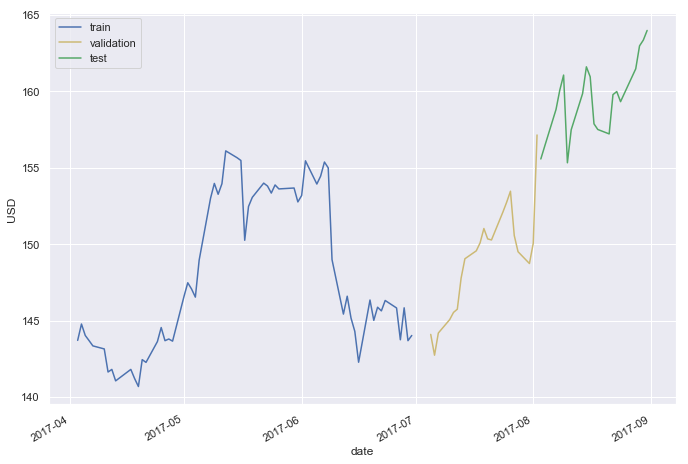

In [562]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='Date', y='Adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Naturellement, on retrouve une courbe assez bougente à gauche et une tendance haussière à partir du mois de juillet. 

## Predict using Moving Average

In [563]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'Adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['Adj_close'])))
    mape.append(get_mape(cv['Adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

C:\Users\Hass\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in less

C:\Users\Hass\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in less



RMSE = [1.9397127917002766, 2.198187835901358]
MAPE = [0.8456226176105053, 1.038766910766782]


,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS,Days,Hours
0,2017-04-03 13:30:00,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350,2017-04-03,13:30
1,2017-04-03 13:31:00,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350,2017-04-03,13:31
2,2017-04-03 13:32:00,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365,2017-04-03,13:32
3,2017-04-03 13:33:00,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380,2017-04-03,13:33
4,2017-04-03 13:34:00,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240,2017-04-03,13:34


Text(0, 0.5, 'RMSE')

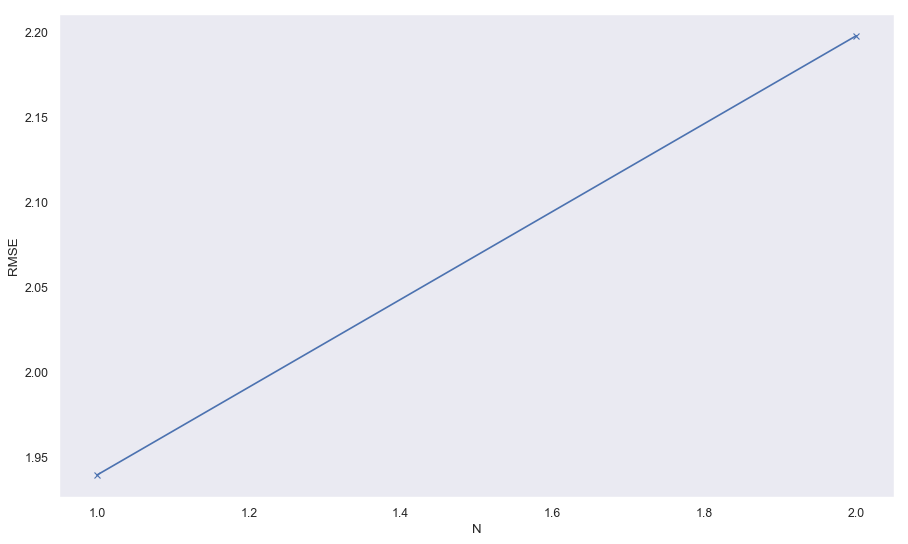

In [564]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE')

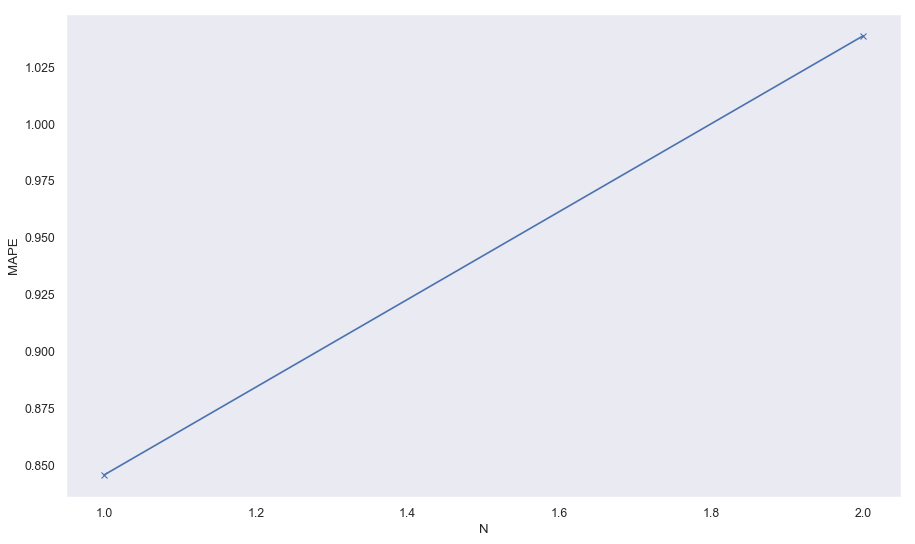

In [565]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [566]:
# Set optimum N
N_opt = 1

## Plot prediction on dev set

Text(0, 0.5, 'USD')

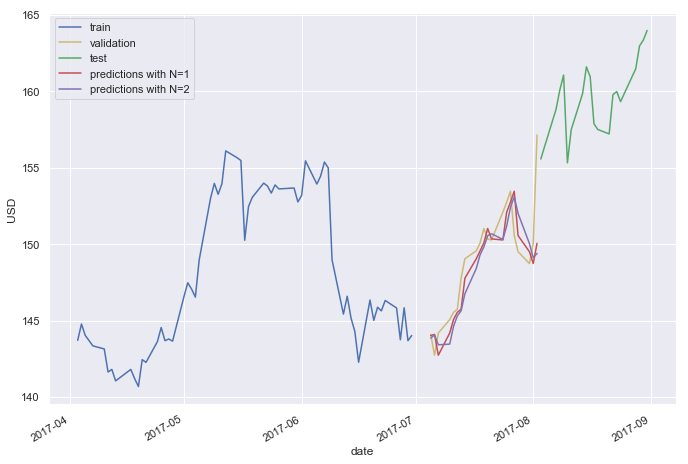

In [567]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = train.plot(x='Date', y='Adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Comme on peut le voir, la couleur violet et rouge ont mis en évidence la prévision du prix des actions basée sur la moyenne mobile. A partir des données présLa prévision prévoyait une baisse pour une petite période pas trop longue, puis une hausse et ensuite une baisse en fin du mois. Par conséquent, on pourrait acheter des actions pendant la baisse et les vendre pendant la hausse.

NameError: name 'Date' is not defined

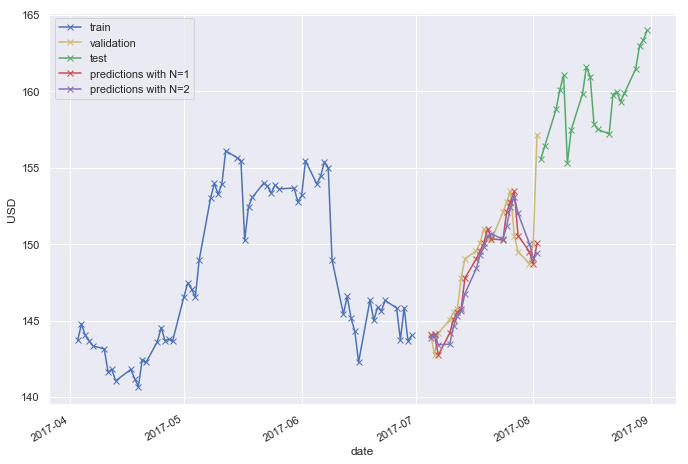

In [579]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Adj_close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='Date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([Date(2017, 7, 1), Date(2017, 8, 31)])
ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

## Final Model

In [576]:
est_list = get_preds_mov_avg(df5, 'Adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['Adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['Adj_close'], est_list))
test.head()

C:\Users\Hass\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in less



RMSE = 1.961
MAPE = 0.947%


,Date,Adj_close,est_N1
84,2017-08-03,155.57,157.14
85,2017-08-04,156.39,155.57
86,2017-08-07,158.81,156.39
87,2017-08-08,160.08,158.81
88,2017-08-09,161.06,160.08


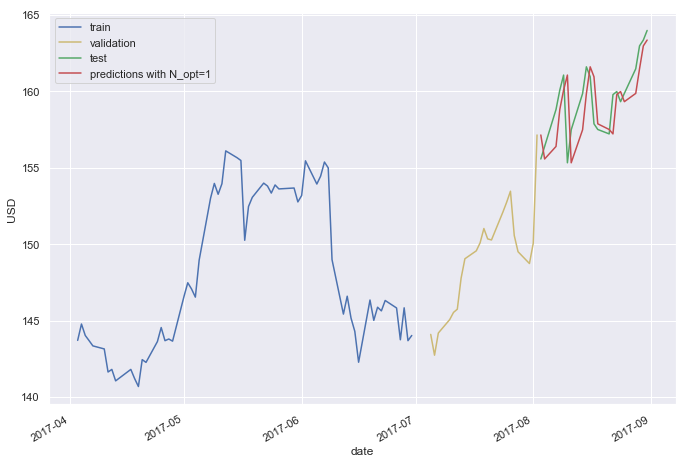

In [577]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Adj_close', style='b-', grid=True)
ax = cv.plot(x='Date', y='Adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
matplotlib.rcParams.update({'font.size': 14})

Ici, nous visualiserons la courbe avec nos données historiques existantes. Ce qui nous permet de visualiser le comportement du modèle pour prévoir la fixation future des prix des actions. Le modèle arrive à capturer à la fois la partie saisonnière et la tendance des données passées. 
Le prix des actions dépend fortement de ce qui se passe actuellement sur le marché et, par conséquent, les prix augmentent et diminuent. 

NameError: name 'Date' is not defined

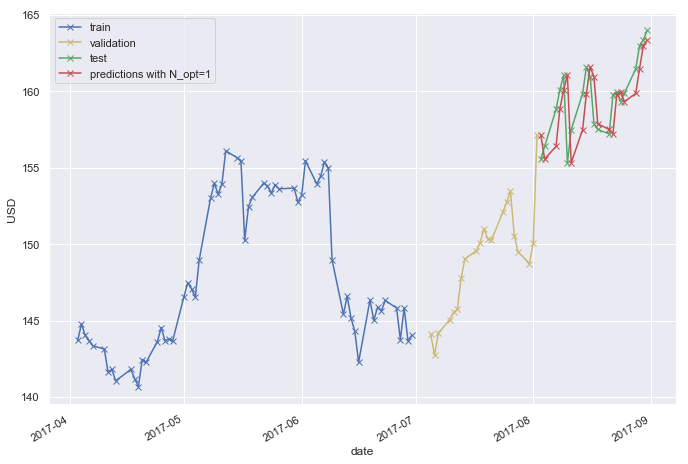

In [583]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='Date', y='Adj_close', style='bx-', grid=True)
ax = cv.plot(x='Date', y='Adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='Adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='Date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([Date(2017, 8, 1), Date(2017, 9, 31)])
ax.set_ylim([144, 165])
ax.set_title('Zoom in to test set')

In [585]:
# Save as csv
test_last_value = test
test_last_value.to_csv("C:/Users/Hass/Downloads/Master_IMSD/Réseau de Neurones/test_last_value.csv")

## Findings

In [632]:
# Compare various methods
results_dict = {'method': ['Last Value'],
                'RMSE': [1.961],
                'MAPE(%)': [0.947]}
results = pd.DataFrame(results_dict)
results

,method,RMSE,MAPE(%)
0,Last Value,1.961,0.947


Avec une RMSE de 1.961 et une MAPE de 0.947%, c'est-à-dire en moyenne, la prévision est erronée de 0.947%. Nous pouvons dire que le modèle généralement bon.

In [ ]:
# Read all dataframes for the different methods
test_last_value = pd.read_csv("C:/Users/Hass/Downloads/Master_IMSD/Réseau de Neurones/test_last_value.csv", index_col=0)
test_last_value.loc[:, 'Date'] = pd.to_datetime(test_last_value['Date'],format='%Y-%m-%d')